In [142]:
import pandas as pd
import numpy as np
import gpflow
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import tensorflow as tf

import utils as u
from models import LongTermPartial_Model
%matplotlib inline


%load_ext autoreload
%autoreload 2

sns.set()
sns.set_style('white')
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['figure.dpi'] = 100

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
data = pd.read_csv('../data/gp_weekly_nta_data.csv')
data['DATETIME'] = pd.to_datetime(data['DATETIME'])

data.DATE_IND = data.DATE_IND.astype(float)  # try to bring down variance scale

data.rename(columns={'INJURED':'COUNT'},inplace=True)

data.COUNT = data.COUNT.astype(float)

#data = data[data.BoroName == 'Manhattan']



In [83]:
e_s = ((696/100000) * 8*10**6) / 52

e_s

1070.7692307692307

In [84]:
city_data = data.groupby('DATETIME')[['COUNT']].sum()
city_data['DATE_IND'] = range(0,city_data.shape[0]) 
city_data['DATE_IND'] += 1
city_data.DATE_IND = city_data.DATE_IND.astype(float) / 100
#city_data.DATE_IND = (city_data.DATE_IND - city_data.DATE_IND.mean()) / city_data.DATE_IND.std()
city_data = city_data.iloc[2:] # drop first week
city_data.reset_index(inplace = True)
city_data.head()

,DATETIME,COUNT,DATE_IND
0,2012-07-15,827.0,0.03
1,2012-07-22,838.0,0.04
2,2012-07-29,802.0,0.05
3,2012-08-05,792.0,0.06
4,2012-08-12,836.0,0.07


In [85]:
search_periods = [[156,52]]

In [86]:
for i, s in enumerate(search_periods):
    
    print('Beginning run {} : '.format(str(s)))
    #print('{} periods for training \n').format(s[0])
    #print('{} periods for testing \n').format(s[1])

    data_dict = u.preprocess(city_data, start_date= '2012/07/15', training_end_date= s[0], \
                                                           testing_end_date=s[1], time_only = True)


    m = LongTermPartial_Model(data_dict['X_train'],data_dict['y_train'],use_priors=True, e_s= e_s , period = 1)
    m.compile()
    opt = gpflow.train.ScipyOptimizer()
    print('Initial neg. log-likelihood: {}'.format(str(m.compute_log_likelihood())))
    opt.minimize(m, maxiter = 20000)
    
    #u.pred_GP(m,data_dict)
    #test = data_dict['test']

    #gp = test.groupby('DATETIME')['gp_sq_error'].mean() #/ test.GRID_SQUARE.max()
    #ar = u.run_AR(data_dict)
    #summary = pd.concat([gp,ar],axis=1)
    #summary.plot()

    #print(summary.mean())


Beginning run [156, 52] : 
Training ends on: 2015-07-12 00:00:00
testing ends on: 2016-07-10 00:00:00
Initial neg. log-likelihood: -578784.892583
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 1179.870860
  Number of iterations: 3897
  Number of functions evaluations: 4204


added gp pred and error to test


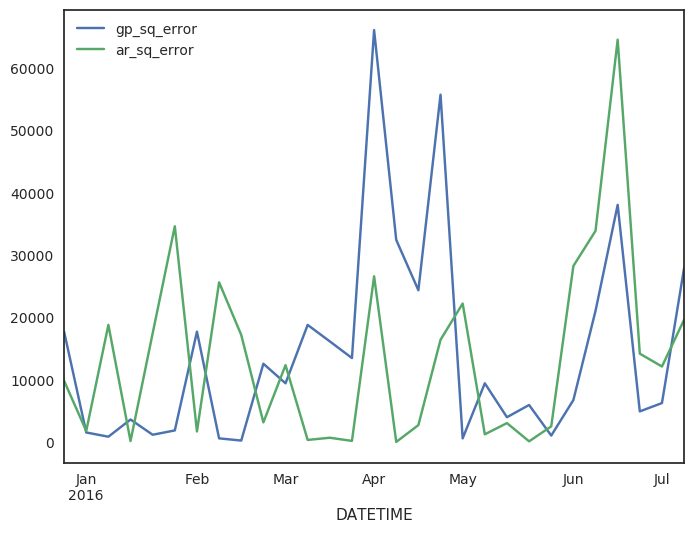

In [143]:
ar, ar_error = u.run_AR(data_dict, group_by=None)
ar_se = pd.Series(np.square(ar_error))
u.pred_GP(m,data_dict)

se = data_dict['test'][['gp_sq_error']].copy()
se['ar_sq_error'] = ar_se.values
se[24:].plot()

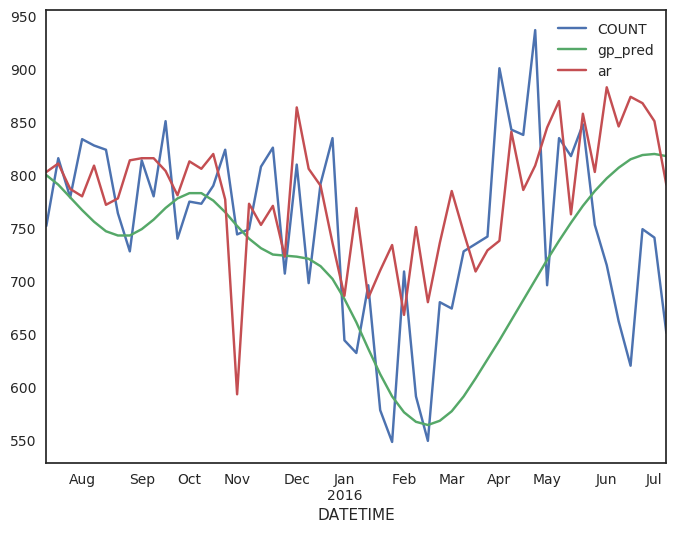

In [144]:
pr = data_dict['test'][['COUNT','gp_pred']].copy()
pr['ar'] = ar

pr.plot()

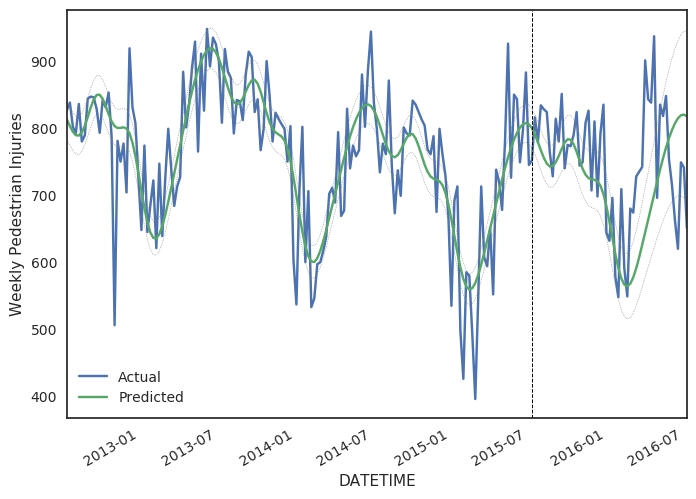

In [145]:
pred_train = m.predict_y(data_dict['X_train'])
pred_test = m.predict_y(data_dict['X_test'])

train = data_dict['train']
train['gp_pred'] = pred_train[0]
train['gp_var'] = pred_train[1]

test = data_dict['test']
test['gp_pred'] = pred_test[0]
test['gp_var'] = pred_test[1]


pred = train.append(test)[['COUNT','gp_pred','gp_var']]
pred['gp_err'] = np.sqrt(pred.gp_var)
pred['err_upper'] = pred.gp_pred + np.sqrt(pred.gp_var) * .95
pred['err_lower'] = pred.gp_pred - np.sqrt(pred.gp_var) * .95
pred['e_err'] = pred.COUNT - e_s


pred[['COUNT','gp_pred']].plot()
plt.ylabel('Weekly Pedestrian Injuries')
plt.legend(['Actual','Predicted'])
plt.axvline('2015-07-12', linestyle='--', color = 'black', linewidth = 0.7)
plt.plot(pred.err_lower, linestyle = ':', color = 'grey', linewidth = 0.5)
plt.plot(pred.err_upper, linestyle = ':', color = 'grey', linewidth = 0.5)


## This needs:
# train/test normalization has to be split
# prediction has to be done right when looking ahead (sequentially)


In [90]:

((pred.COUNT > pred.err_upper) | (pred.gp_pred < pred.err_lower)).sum() / pred.shape[0]

0.36666666666666664

In [ ]:
## Reduction in variance

def calc_var_reduction(c):
    return 1 - (np.square(pred[c]-pred.COUNT).sum() / np.square(pred[['e_err']]).sum())

calc_var_reduction('gp_pred')

In [134]:
X = np.vstack((data_dict['X_train'],(data_dict['X_test']) ))
y = np.vstack((data_dict['y_train'],(data_dict['y_test']) ))
mu_lin, _ = m.predict_f_linear(X)
mu_period, _ = m.predict_f_periodic(X)
mu_rbf, _ = m.predict_f_rbf(X)

mu_comb = mu_lin + mu_period + mu_rbf

comps = {'lin': mu_lin , 'period': mu_period , 'rbf': mu_rbf}


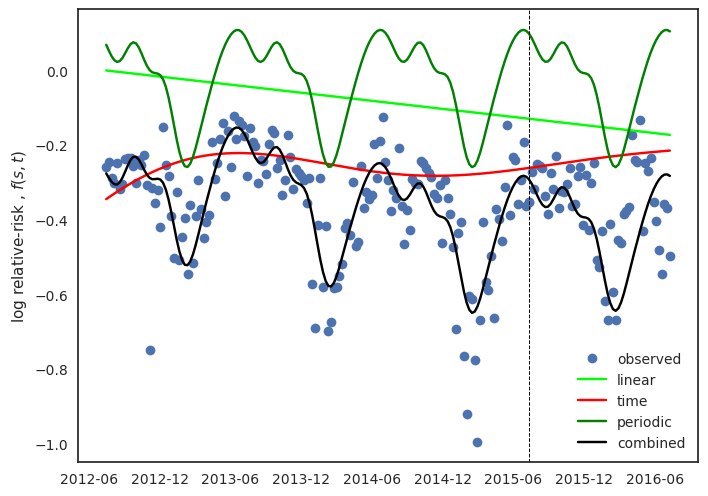

In [146]:
idx = pred.index.values

f , _ = m.predict_f(X)
observed = np.log(y / e_s)
plt.plot(idx,observed,'o', label = 'observed')
plt.plot(idx, mu_lin ,'lime',label = 'linear')
plt.plot(idx, mu_rbf, 'red' ,label='time')
plt.plot(idx, mu_period, 'green', label='periodic')
#plt.plot(X, f, 'grey')
plt.plot(idx, mu_comb, 'black',label='combined')
plt.legend()
plt.ylabel('log relative-risk , $f(s,t)$')
plt.axvline('2015-07-12', linestyle='--', color = 'black', linewidth = 0.7)


In [136]:
for c in comps.keys():
    pred['pred_{}'.format(c)] = np.exp(comps[c]) * e_s
    print(c)
    print(calc_var_reduction('pred_{}'.format(c)))

lin
e_err    0.431646
dtype: float64
period
e_err    0.134796
dtype: float64
rbf
e_err    0.852263
dtype: float64


In [121]:
 np.square(pred['pred_rbf'] - pred.COUNT).sum() / np.square(pred['e_err']).sum()

0.85226259036756136

In [148]:
m.as_pandas_table().to_csv('files/citywide_summary_table.csv')